# Predictive Maintenance - Pump Sensor Data

## load libraies

In [1]:
#basic
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pickle
import time
import keras
import itertools


#encoding 
from sklearn.preprocessing import OneHotEncoder

#normalization
from sklearn.preprocessing import MinMaxScaler

#PCA 
from sklearn.decomposition import PCA

#Model
import tensorflow as tf
from tensorflow import keras
from keras import Sequential

# fit the network
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import fbeta_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, GRU


# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [2]:
df = pd.read_csv('../input/pump-sensor-data/sensor.csv', index_col=0)

<p style="font-size:20px"><b>Handling Missing Data </b>:</p>

In [3]:
df = pd.read_csv('../input/pump-sensor-data/sensor.csv')
df = df.drop(['sensor_15' ], axis = 1)
df = df.iloc[1:]
df = df.fillna(method='ffill')
df.isnull().sum().sum()

0

<p style="font-size:30px"><b>Data Preprocessing</b>:</p>

In [4]:
#smoothly interpolate given data points
df.interpolate(method='akima', inplace=True)

In [5]:
#In turn, machine_status is a categorical feature. Thus it needs to be one hot encoded.
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(df[['machine_status']]).toarray()
df_one_hot = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names().tolist())
df_one_hot.head()

,x0_BROKEN,x0_NORMAL,x0_RECOVERING
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [6]:
#replace categorical column with one hot encoded
try:
    df.drop(['machine_status'], axis=1, inplace=True)
except KeyError as e:
    print("Column does not exist:  ", str(e))
    
#inner join tables on index

#make sure arrays have the same number of rows
if df.shape[0] == df_one_hot.shape[0]:
    df = pd.concat([df, df_one_hot], axis=1, join='inner')
else:
    print("Different number of rows.")

In [7]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,x0_BROKEN,x0_NORMAL,x0_RECOVERING
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0.0,1.0,0.0
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,0.0,1.0,0.0
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,0.0,1.0,0.0
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,0.0,1.0,0.0
5,5,2018-04-01 00:05:00,2.453588,47.09201,53.1684,46.397568,637.6157,78.18568,13.41146,16.16753,...,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,0.0,1.0,0.0


<p style="font-size:40px"><b>PCA</b>:</p>

In [8]:
#Using PCA.explained_variance_ratio_ to understand what percentage of variance is explained by the data
def apply_PCA(n_components):
    model = PCA(n_components)
    model.fit_transform(df[df.columns.difference(['timestamp', 'x0_BROKEN', 'x0_NORMAL', 'x0_RECOVERING'])])
    
    var_ratio = model.explained_variance_ratio_
    var_cumu = model.explained_variance_ratio_.cumsum()
    print('Explained variance ratio: \n', var_ratio)
    print('Cumulative variance: \n', var_cumu)
    
    X = np.arange(1, n_components+1)
    plt.vlines(x=7, ymax=1.2, ymin=0, colors="m", linestyles="--")
    plt.hlines(y=0.95, xmax=20, xmin=0, colors="g", linestyles="--")

    plt.scatter(x=X, y=var_ratio, marker='v', c='b')
    plt.scatter(x=X, y=var_cumu, marker = 'o', c='r')
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    
    return model

Explained variance ratio: 
 [9.99770562e-01 1.56463106e-04 2.20527535e-05 1.03277105e-05
 8.35145279e-06 7.15158690e-06 4.82518316e-06 4.32323158e-06
 3.89396693e-06 2.80128238e-06 2.22591830e-06 1.64426943e-06
 1.25333070e-06 9.38092740e-07 6.55420765e-07 5.67567865e-07
 4.34304070e-07 2.64407615e-07 1.99086846e-07 1.83701175e-07]
Cumulative variance: 
 [0.99977056 0.99992703 0.99994908 0.99995941 0.99996776 0.99997491
 0.99997973 0.99998406 0.99998795 0.99999075 0.99999298 0.99999462
 0.99999588 0.99999681 0.99999747 0.99999804 0.99999847 0.99999874
 0.99999894 0.99999912]


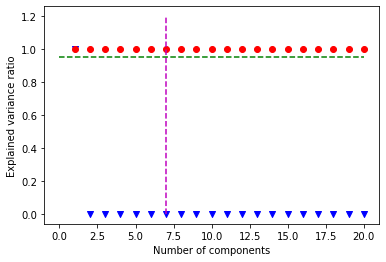

In [9]:
# Viewing the PCA components 
pca_model = apply_PCA(20)

<p style="font-size:30px"><b>Data Transformation</b>:</p>


In [10]:
#Standardize data within every machine status .
def grouper(table, column_name):
    table_1 = table[column_name]
    grouper = (table_1 != table_1.shift()).cumsum()
    return grouper

In [11]:
df['normal_time'] = df.groupby(grouper(df, 'x0_NORMAL'))['x0_NORMAL'].cumsum()
df['broken_time'] = df.groupby(grouper(df, 'x0_BROKEN'))['x0_BROKEN'].cumsum()
df['recovering_time'] = df.groupby(grouper(df, 'x0_RECOVERING'))['x0_RECOVERING'].cumsum()

In [12]:
difference = df['broken_time'].diff()
difference.loc[difference==1]
print('Data covers: ' + str(int(len(df)/60/24)) + ' days.')

Data covers: 152 days.


In [13]:
#Lets try to classify, whether pump will break in the next day.
def add_broken_alert(df, n):
    """Add alert to the dataset to indicate that failure will be in [n] days"""
    num_of_periods = n*24*60
    col_name = 'fail_in_' + str(n) + '_days'
    broken_index = df.loc[df['x0_BROKEN']==1].index
    df[col_name] = df['x0_BROKEN']
    for i in broken_index:
        df.loc[(int(i)-200): i, col_name] = 1
    return df

In [14]:
df = add_broken_alert(df, 1)
df = add_broken_alert(df, 3)
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_50,sensor_51,x0_BROKEN,x0_NORMAL,x0_RECOVERING,normal_time,broken_time,recovering_time,fail_in_1_days,fail_in_3_days
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,243.0556,201.3889,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,241.3194,203.7037,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,240.4514,203.1250,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,242.1875,201.3889,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0
5,5,2018-04-01 00:05:00,2.453588,47.09201,53.1684,46.397568,637.6157,78.18568,13.41146,16.16753,...,241.6088,201.6782,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0


<p style="font-size:30px"><b>Train/Test</b>:</p>

In [15]:
#drop some unnecessary columns
try:
    df.drop(['timestamp'], axis=1, inplace=True)
except KeyError as e:
    print("Column does not exist:  ", str(e))

In [16]:
#Data ingestion
df_train = df.copy()
df_validation = df.copy()
df_test = df.copy()
#We divide data into three sets: train(55%), validation(25%) and test(20%)
df_train = df_train[df_train.index <= round(len(df)*0.75)]
df_validation = df_validation[(df_validation.index > round(len(df)*0.55)) & (df_validation.index <= round(len(df)*0.8))]
df_test = df_test[df_test.index > round(len(df)*0.8)]

In [17]:
print('Size of: \n train set: {} \n validation set: {} \n test set {}'.format(len(df_train), len(df_validation), len(df_test)))

Size of: 
 train set: 165238 
 validation set: 55079 
 test set 44064


<p style="font-size:30px"><b>Normalise the Datasets with MinMaxScaler</b>:</p>

In [18]:
min_max = MinMaxScaler()
norm_cols = df.columns.tolist()

In [19]:
# MinMax normalization
df_train_norm = pd.DataFrame(min_max.fit_transform(df_train), columns=norm_cols, index=df_train.index)
df_validation_norm = pd.DataFrame(min_max.fit_transform(df_validation), columns=norm_cols, index=df_validation.index)
df_test_norm = pd.DataFrame(min_max.fit_transform(df_test), columns=norm_cols, index=df_test.index)

Determining the features of interest, since feature engineering is specific to the problem scenario and the available data

In [20]:
# Let's take for a sequence length 60 periods. It sums up to 1 hour.
seq_len = 60
sensor_cols=[column for column in df.columns if not column.find('sensor')] # pick the feature columns 

In [21]:
df_train_norm_data = df_train_norm.drop(['fail_in_1_days', 'fail_in_3_days'], axis=1)
df_train_norm_label = df_train_norm['fail_in_1_days']
sensor_cols

['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_05',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26',
 'sensor_27',
 'sensor_28',
 'sensor_29',
 'sensor_30',
 'sensor_31',
 'sensor_32',
 'sensor_33',
 'sensor_34',
 'sensor_35',
 'sensor_36',
 'sensor_37',
 'sensor_38',
 'sensor_39',
 'sensor_40',
 'sensor_41',
 'sensor_42',
 'sensor_43',
 'sensor_44',
 'sensor_45',
 'sensor_46',
 'sensor_47',
 'sensor_48',
 'sensor_49',
 'sensor_50',
 'sensor_51']

<p style="font-size:15px"><b> Keras LSTM layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.</b></p>

In [22]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
        data_matrix = id_df[sensor_cols].values
        num_elements = data_matrix.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_matrix[start:stop, :]
            
#We also create a function to label these sequences.

def generate_label(sequence_len, df):
    data_matrix = df.values     # For one id I put all the labels in a single matrix.
    num_of_elements = data_matrix.shape[0]  
    return data_matrix[sequence_len:num_of_elements]

In [23]:
seq_gen = [list(gen_sequence(df_train_norm_data, seq_len, sensor_cols))]
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(165178, 60, 51)


In [24]:
# generate labels
label_array = generate_label(seq_len, df_train_norm_label)

In [25]:
label_array = label_array.reshape(label_array.shape[0], 1)

In [26]:
label_array.shape

(165178, 1)

In [27]:
np.save('seq_array', seq_array)
np.save('label_array', label_array)

# LSTM Model

In [28]:
# Feature weights
number_of_features = seq_array.shape[2]
number_outcome = label_array.shape[1]

## build the network
model_path = 'binary_model.h5'

model = Sequential()

# LSTM model
model.add(LSTM(
            input_shape=(seq_len , number_of_features),
            units=100,
            return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(
            units=50,
            return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(
            units=number_outcome,
            activation='sigmoid'))

In [29]:
## With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [30]:
## Verify the architecture 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           60800     
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 91,051
Trainable params: 91,051
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history = model.fit(seq_array,
          label_array,
          epochs=30,
          batch_size=200,
          validation_split=0.10,
          verbose=1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',#To prevent overfitting
                                                             min_delta=0,
                                                             patience=5,
                                                             verbose=0, 
                                                             mode='auto')])

Epoch 1/30
744/744 [==============================] - 148s 198ms/step - loss: 0.0496 - accuracy: 0.9906 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 2/30
744/744 [==============================] - 146s 196ms/step - loss: 0.0415 - accuracy: 0.9922 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 3/30
744/744 [==============================] - 145s 195ms/step - loss: 0.0375 - accuracy: 0.9922 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/30
744/744 [==============================] - 146s 196ms/step - loss: 0.0316 - accuracy: 0.9930 - val_loss: 2.6344e-04 - val_accuracy: 1.0000
Epoch 5/30
744/744 [==============================] - 147s 197ms/step - loss: 0.0302 - accuracy: 0.9927 - val_loss: 1.4132e-04 - val_accuracy: 1.0000
Epoch 6/30
744/744 [==============================] - 145s 195ms/step - loss: 0.0275 - accuracy: 0.9927 - val_loss: 3.6885e-04 - val_accuracy: 1.0000
Epoch 7/30
744/744 [==============================] - 148s 199ms/step - loss: 0.0264 - accuracy: 0.9931 - val_lo

# Our Model Performance

In [32]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))

826/826 [==============================] - 65s 78ms/step - loss: 0.0191 - accuracy: 0.9937
Training Accurracy: 0.9937219023704529


In [33]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [34]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=600)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

276/276 [==============================] - 48s 174ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[163940     32]
 [  1005    201]]


In [35]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[163940     32]
 [  1005    201]]


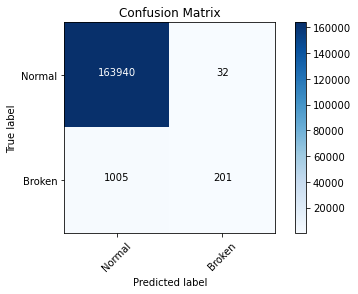

In [36]:
cm_plot_labels = ['Normal','Broken']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [37]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'Training Precision: ', precision, '\n', 'Training Recall: ', recall, '\n', 'Training F1 Score:', f1)
print(fbeta_score(y_true, y_pred,beta=0.5))

Training Precision:  0.8626609442060086 
 Training Recall:  0.16666666666666666 
 Training F1 Score: 0.27936066712995133
0.4700654817586529


# To be continued 

# Grid LSTM Model 